# Mitigating Sex Bias in Heart Disease Diagnosis

#### Trustworthy AI Examples Series

This notebook demonstrates how biological sex can introduce unfair biases in a heart disease diagnosis. Using the Heart Disease dataset, this example scenario simulates a diagnostic pipeline that predicts the presence of heart disease in an individual based on clinical and demographic features. Bias mitigation is then performed, targeting false negative rate disparities between male and female patients by applying pre-processing, in-processing, and post-processing fairness techniques, ultimately comparing their performance by measuring false negative rate across sex groups to build a more trustworthy prediction system.

Women often present different symptoms of heart disease than men, yet clinical models trained on male-dominated datasets may underdiagnose women. This can lead to delayed treatment and worse outcomes for female patients.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why sex-based underdiagnosis occurs in clinical prediction.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to bias measurement to mitigation.
3. **Apply fairness strategies in-context**: using residualization + resampling, fairness-constrained optimization, and threshold adjustment to balance false negative rate.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### Fairlearn

**Fairlearn** is a specialized library for evaluating and improving fairness in machine learning models. It is used here for:

#### Fairness Assessment

- `MetricFrame`: computes metrics separately for each group.
- `false_negative_rate`: measures the proportion of positive cases a model misses within each group.

#### Bias Mitigation

- `TruePositiveRateParity`: ensures that the proportion of actual positives correctly predicted is the same across all groups defined by a protected attribute.
- `ExponentiatedGradient`: an in-processing technique that reweights examples during training to enforce fairness constraints.
- `ThresholdOptimizer`: a post-processing tool that adjusts decision thresholds per group to equalize outcomes after the model has already been trained.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

from fairlearn.metrics import MetricFrame, false_negative_rate
from fairlearn.reductions import ExponentiatedGradient, TruePositiveRateParity
from fairlearn.postprocessing import ThresholdOptimizer

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Heart Disease dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

In [3]:
file_path = PROJECT_ROOT / 'data/heart_disease.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

display(df.describe())
df.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex,cp,exang,slope,thal,restecg,fbs,target
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,54.351974,131.684211,246.315789,149.723684,1.036184,0.661184,0.680921,0.960526,0.325658,1.401316,1.151316,0.523026,0.148026,0.457237
std,9.150256,17.570949,52.108280,22.927263,1.160690,0.933608,0.466888,1.030118,0.469393,0.616172,0.959647,0.526019,0.355712,0.498989
min,28.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.750000,120.000000,211.000000,133.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,55.500000,130.000000,240.500000,153.000000,0.800000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000


,age,trestbps,chol,thalch,oldpeak,ca,sex,cp,exang,slope,thal,restecg,fbs,target
0,63,145,233,150,2.3,0.0,1,3,0,0,1,0,1,0
1,67,160,286,108,1.5,3.0,1,0,1,1,2,0,0,1
2,67,120,229,129,2.6,2.0,1,0,1,1,0,0,0,1
3,37,130,250,187,3.5,0.0,1,2,0,0,2,1,0,0
4,41,130,204,172,1.4,0.0,0,1,0,2,2,0,0,0


### Feature Transformation

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target and sensitive attributes to preserve their interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

It is recommended to avoid altering the target variable, `target`, and sensitive attribute, `sex`, as as modifying these can obscure group-level disparities and make fairness evaluation more difficult.

A stratified split is performed using `train_test_split` to preserve the distribution of the target variable across both sets, which is particularly important for imbalanced classification problems.

In [4]:
target_col = 'target'
sensitive_col = 'sex'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col, sensitive_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]
g = df_scaled[sensitive_col]

stratify_labels = df_scaled[target_col].astype(str) + '_' + df_scaled[sensitive_col].astype(str)

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, g, test_size=0.2, random_state=42, stratify=stratify_labels)

### Correlation Analysis & Proxy Feature Flagging

After preprocessing, a correlation analysis is performed to understand relationships between features and identify potential proxy features. Proxy features are features that may indirectly encode sensitive information. In the example below, one can see that `thal` and `chol` have the highest correlation to `sex`, with correlations of -0.36 and -0.20 respectively. This gives reason to suspect that they may introduce indirect bias by allowing the model to infer `sex`.

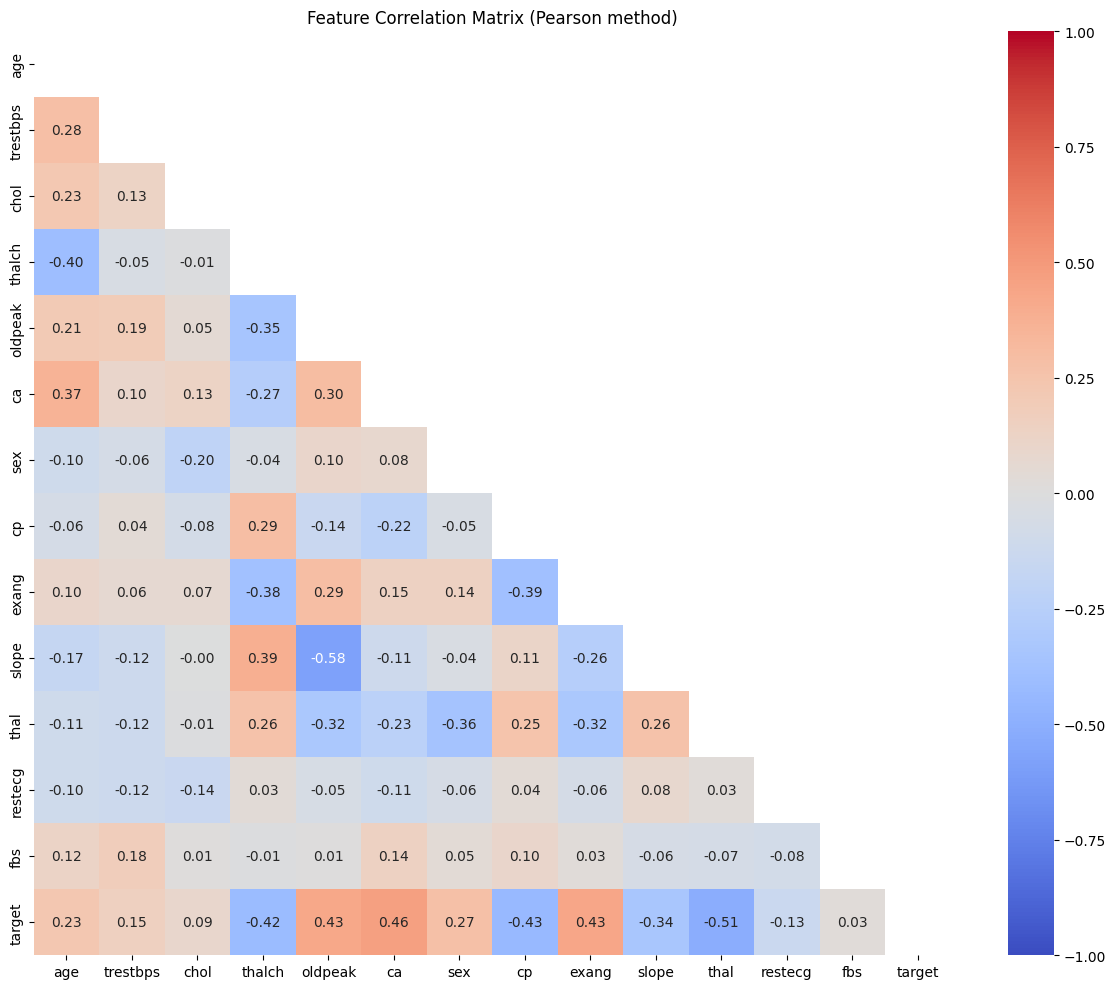

Identified proxy features: {'sex': ['thal', 'target', 'chol']}


In [5]:
pp.correlation_matrix(df)
proxy_dict = pp.identify_proxy_variables(df, sensitive_attrs=[sensitive_col], method='relative')
print("Identified proxy features:", proxy_dict)

### Proxy Feature Plots

After identifying potential proxy features, their correlation to the sensitive variable, `sex`, will be verified. An examination of the distributions for `chol` and `thal` reveals that they are skewed and may encode information related to `sex`. More specifically, males (`sex=1`) show slightly higher and more concentrated `chol` values, while `thal` exhibits distinct categorical peaks that differ between males and females, suggesting it may act as a stronger proxy for sex.

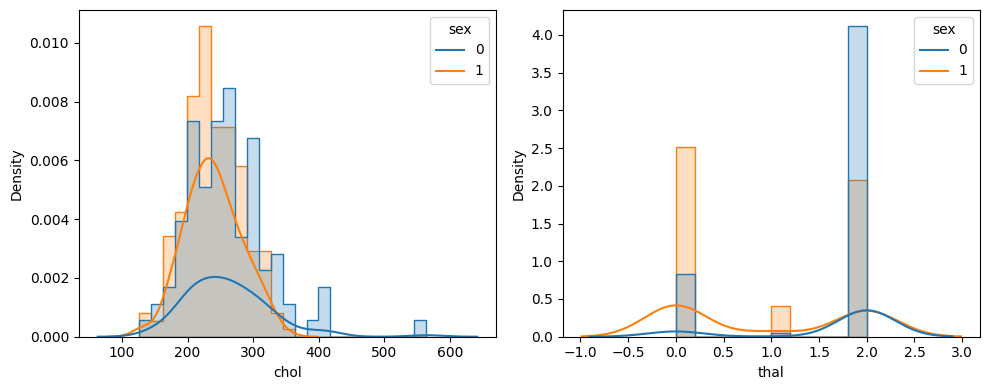

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=df, x="chol", hue="sex", element="step", stat="density", common_norm=False, ax=axes[0])
sns.kdeplot(data=df, x="chol", hue="sex", ax=axes[0])

sns.histplot(data=df, x="thal", hue="sex", element="step", stat="density", common_norm=False, ax=axes[1])
sns.kdeplot(data=df, x="thal", hue="sex", ax=axes[1])

plt.tight_layout()
plt.show()

### Proxy Modeling

Proxy modeling involves training a predictive model to determine whether certain features can be used to infer a sensitive attribute. If the model achieves high accuracy and ROC-AUC, it suggests that these features encode information about the sensitive attribute, even if indirectly.

Proxy modeling is a strong indicator of potential bias. In this scenario, a logistic regression model is used to predict `sex` with only `thal` and `chol`. Since `sex` is an categorical variable on a scale from 0 to 1, random guessing would yield an expected accuracy of ~50.0% and AUC of ~0.5. The model achieved an accuracy of 73.8% and AUC of 0.733, clearly far removed from random guessing. This indicates that these features carry significant information about the sensitive attribute and can act as proxy features.

From a practical standpoint, thalassemia (`thal`) may correlate with sex due to genetic and diagnostic differences. Certain forms of the condition express differently in males and females, and clinical assessments like stress tests may reflect these variations. Cholesterol (`chol`) levels also vary by sex, influenced by hormonal differences such as estrogen's role in lipid metabolism, as well as age-related trends and treatment disparities.

In [7]:
proxy_features = ['chol', 'thal']

df_proxy =  df[proxy_features + [sensitive_col]]

X_proxy = df_proxy[proxy_features]
y_proxy = df_proxy[sensitive_col]
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(X_proxy, y_proxy, test_size=0.2, random_state=42)

proxy_model = LogisticRegression(max_iter=1000, random_state=42)
proxy_model.fit(X_train_proxy, y_train_proxy)

y_pred_proxy = proxy_model.predict(X_test_proxy)
y_pred_proba = proxy_model.predict_proba(X_test_proxy)[:, 1]
print(f"Proxy Model Accuracy: {accuracy_score(y_test_proxy, y_pred_proxy):.3f}")
print(f"Proxy Model AUC: {roc_auc_score(y_test_proxy, y_pred_proba):.3f}")

Proxy Model Accuracy: 0.738
Proxy Model AUC: 0.733


## Baseline Model

To establish a performance benchmark, a baseline supervised classifier is trained using all features, including sensitive attribute `sex` and proxy features `thal` and `chol`. The baseline quantifies the model’s unconstrained behavior and exposes any initial disparities (for example, a higher female FNR). These baseline numbers define the reference point for measuring the effect of later mitigation strategies.

In [8]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Baseline Accuracy Evaluation

After training the baseline logistic regression model, its performance is evaluated using accuracy and ROC AUC. Accuracy measures the proportion of correct predictions, while ROC AUC reflects the model's ability to distinguish between classes across different thresholds.

The baseline model achieves a high overall accuracy (82.0%) and high ROC AUC (0.878), indicating excellent model performance.

In [9]:
y_pred = baseline_model.predict(X_test)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.820
ROC AUC: 0.878


### Baseline Fairness Evaluation

To assess fairness in the baseline model, the false negative rate across groups defined by the sensitive attribute `sex` is examined. In this case, false negative rate is the proportion of individuals who actually have heart disease but were incorrectly classified as not having heart disease. Using `MetricFrame`, false negative rates are computed separately for each group to visualize the disparity.

This result reveals a notable disparity: individuals identified as female are significantly more likely to be incorrectly classified as not having heart disease (FNR = 0.6) compared to those identified as male (0.217391). Medical datasets often reflect historical biases in diagnosis and treatment. Heart disease symptoms in women are sometimes underdiagnosed or present differently, leading to underdiagnosis in machine learning models.

Baseline False Negative Rate by sex:


,False Negative Rate
sex,
Female,0.600000
Male,0.217391


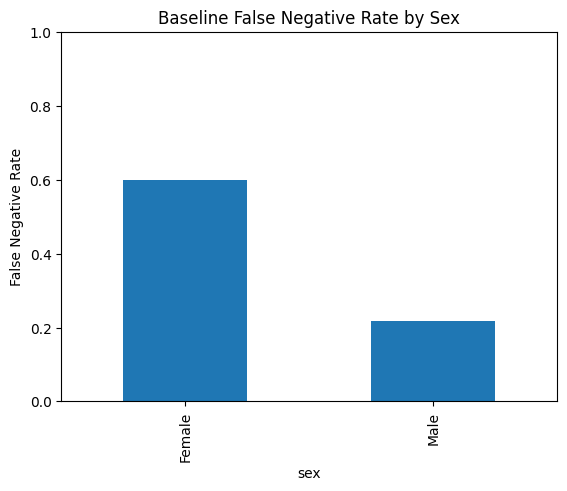

In [10]:
mf_base = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=g_test.replace({0: 'Female', 1: 'Male'})
)
print("Baseline False Negative Rate by sex:")
display(mf_base.by_group)

mf_base.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Baseline False Negative Rate by Sex'); plt.ylim(0,1); plt.show()

## Proxy Debiasing

Most simple bias mitigation techniques only involve removing the sensitive attribute, but more steps are often needed to address indirect bias introduced through proxy features.

To achieve a more equitable prediction system, a custom `ProxyFeatureDebiaser` model is used, which transforms proxy features (`thal`, `chol`) to reduce their ability to predict the sensitive attribute. This technique works by minimizing the statistical dependence between the proxy features and the sensitive attribute, effectively eliminating their role as indirect encoders of bias.

In [11]:
class ProxyFeatureDebiaser(BaseEstimator, TransformerMixin):
    """Debias proxy features with respect to sensitive attribute via residualization using Ridge regression."""
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.models = {}
        self.columns = []

    def fit(self, X, sensitive_attr):
        self.columns = X.columns.tolist()
        for col in self.columns:
            model = Ridge(alpha=self.alpha)
            model.fit(sensitive_attr.values.reshape(-1, 1), X[col].values)
            self.models[col] = model
        return self

    def transform(self, X, sensitive_attr):
        X_new = X.copy()
        for col in self.columns:
            pred = self.models[col].predict(sensitive_attr.values.reshape(-1, 1))
            X_new[col] = X[col] - pred
        return X_new
    
debiaser = ProxyFeatureDebiaser(alpha=1.0)
debiaser.fit(df[proxy_features], df[sensitive_col])

ProxyFeatureDebiaser()

### Reprocessing Data After Debiasing

In order to debias proxy features, the data must be reprocessed. After applying the `ProxyFeatureDebiaser`, re-encode and rescale the dataset to ensure consistency with the original preprocessing pipeline. This step is essential because the debiasing transformation alters the proxy feature distributions, meaning data must be recleaned for training purposes.

In [12]:
df_debiased = df.copy()
df_debiased[proxy_features] = debiaser.transform(df[proxy_features], df[sensitive_col])

df_debiased_enc = pp.encode_categorical_data(df_debiased, method='ordinal', exclude_cols=[target_col, sensitive_col])
df_debiased_scaled = pp.scale_features(df_debiased_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

### Train-Test Split After Debiasing

Following the reprocessing of debiased features, the dataset is split for model training and evaluation. The target (`target`) and sensitive attribute (`sex`) are excluded from the feature set to prevent direct bias. A stratified split based on a combination of `sex` and `target` maintains balanced representations across sensitive groups and target classes.

In [13]:
X_debiased = df_debiased_scaled.drop(columns=[target_col, sensitive_col])

X_train_debiased, X_test_debiased, y_train_debiased, y_test_debiased, g_train_debiased, g_test_debiased = train_test_split(
    X_debiased, y, g,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

### Correlation Check After Debiasing

The correlations between the sensitive attribute and proxy features are examined after debiasing to verify the effectiveness of the `ProxyFeatureDebiaser`. The near-zero correlations indicate that the debiasing process was successful in removing the relationships between the proxy features and the sensitive attribute.

In [14]:
train_df = pd.concat([X_train_debiased, y_train_debiased.rename(target_col), g_train_debiased.rename(sensitive_col)], axis=1)
minority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmin()]
majority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmax()]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_balanced = pd.concat([majority, minority_upsampled])

X_train_debiased = train_balanced.drop(columns=[target_col, sensitive_col])
y_train_debiased = train_balanced[target_col]
g_train_debiased = train_balanced[sensitive_col]

print("Post-debias raw correlation:")
print(pd.concat([df_debiased[sensitive_col].reset_index(drop=True), df_debiased[proxy_features].reset_index(drop=True)], axis=1).corr())

Post-debias raw correlation:
           sex      chol      thal
sex   1.000000 -0.003094 -0.005816
chol -0.003094  1.000000 -0.093648
thal -0.005816 -0.093648  1.000000


## Proxy Debiasing Model

The preprocessed and debiased data is now ready for model training. A logistic regression classifier is chosen for its interpretability and efficiency as a baseline model, allowing for a clear assessment of the impact that the debiasing and balancing procedures have on a standard algorithm. The model is subsequently trained on the prepared feature set (`X_train_debiased`) and corresponding labels (`y_train_debiased`).

In [15]:
debiased_model = LogisticRegression(max_iter=1000, random_state=42)
debiased_model.fit(X_train_debiased, y_train_debiased)

LogisticRegression(max_iter=1000, random_state=42)

### Proxy Debiasing Accuracy Evaluation

After applying proxy debiasing and balancing the training data, the logistic regression model is retrained and evaluated. These results show a notable dencrease in performance (78.7% accuracy, 0.856 ROC AUC) compared to the baseline model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [16]:
y_pred_deb = debiased_model.predict(X_test_debiased)
y_prob_deb = debiased_model.predict_proba(X_test_debiased)[:, 1]

acc_deb = accuracy_score(y_test_debiased, y_pred_deb)
auc_deb = roc_auc_score(y_test_debiased, y_prob_deb)

print("=== Proxy Debiased Model ===")
print(f"Accuracy: {acc_deb:.3f}")
print(f"ROC AUC: {auc_deb:.3f}")

=== Proxy Debiased Model ===
Accuracy: 0.787
ROC AUC: 0.856


### Proxy Debiasing Fairness Evaluation

To assess fairness in the baseline model, the false negative rate across groups defined by the sensitive attribute `sex` is examined. In this case, false negative rate is the proportion of individuals who actually have heart disease but were incorrectly classified as not having heart disease.

After applying proxy debiasing on `thal` and `chol`, FNR for females decreased starkly (0.4). In addition, relatives scores have been significantly reduced between the groups, indicating a substantial improvement in fairness as the model's errors are now more equitably distributed across sex categories. However, this cause the FNR for males to increase from to 0.26087, highlighting the difficulties of fairness parity in complex prediction tasks.

Proxy Debiased False Negative Rate by sex:


,False Negative Rate
sex,
Female,0.40000
Male,0.26087


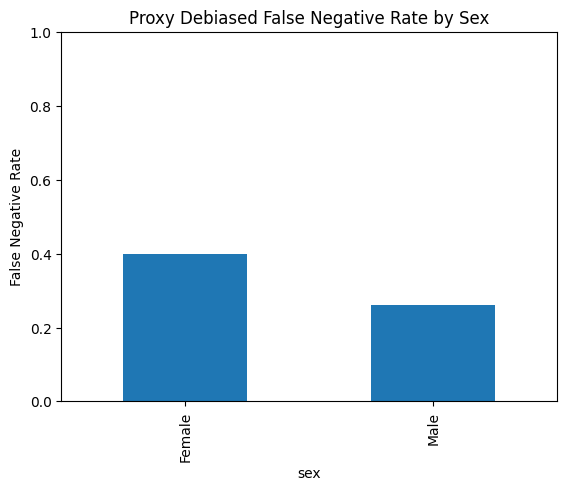

In [17]:
mf_deb = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test_debiased, y_pred=y_pred_deb,
    sensitive_features=g_test_debiased.replace({0: 'Female', 1: 'Male'})
)
print("Proxy Debiased False Negative Rate by sex:")
display(mf_deb.by_group)

mf_deb.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Proxy Debiased False Negative Rate by Sex'); plt.ylim(0, 1); plt.show()

## Exponentiated Gradient Model

To further mitigate bias, the pipeline employs Fairlearn's `ExponentiatedGradient` algorithm with a `TruePositiveRateParity` constraint. This method adjusts the model’s predictions to ensure that the false negative rate is approximately equal across sensitive groups (in this case, sex), while still aiming to preserve predictive performance.

In [18]:
exg_estimator = LogisticRegression(max_iter=1000, random_state=42)
exg = ExponentiatedGradient(estimator=exg_estimator,
                           constraints=TruePositiveRateParity(),
                           eps=0.001)

exg.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x0000023FC8C1B110>,
                      eps=0.001,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.008799162527063526)

### Exponentiated Gradient Accuracy Evaluation

Exponentiated gradient is combined with proxy debiasing, and a new logistic regression model is evaluated. These results show a slight increase in accuracy (82.0%) and decrease in ROC AUC (0.814) compared to the previous model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [19]:
pmf = exg._pmf_predict(X_test_debiased)
y_prob_exg = pmf @ np.array([0, 1])
y_pred_exg = (y_prob_exg >= 0.5).astype(int)

acc_exg = accuracy_score(y_test_debiased, y_pred_exg)
auc_exg = roc_auc_score(y_test_debiased, y_prob_exg)

print("=== Exponentiated Gradient Model ===")
print(f"Accuracy: {acc_exg:.3f}")
print(f"ROC AUC: {auc_exg:.3f}")

=== Exponentiated Gradient Model ===
Accuracy: 0.820
ROC AUC: 0.814


### Exponentiated Gradient Model Fairness Evaluation

After training the new model, fairness is accessed by measuring the false negative rate across sex groups. In this case, false negative rate is the proportion of individuals who actually have heart disease but were incorrectly classified as not having heart disease.

By combining exponentiated gradient with proxy debiasing, FNR for females dropped significantly (0.2) relative to the proxy debiasing model without increasing FNR for males. While proxy debiasing alone reduced some disparities by correcting biased feature representations, it did not fully eliminate unequal treatment. Exponentiated gradient complements proxy debiasing well, as it accounts for residual imbalances left after the initial debiasing pass. Together, they provide stronger protection against unfair outcomes than either method on its own, particularly in mitigating disparities for disadvantaged groups.

Exponentiated Gradient False Negative Rate by sex:


,False Negative Rate
sex,
Female,0.20000
Male,0.26087


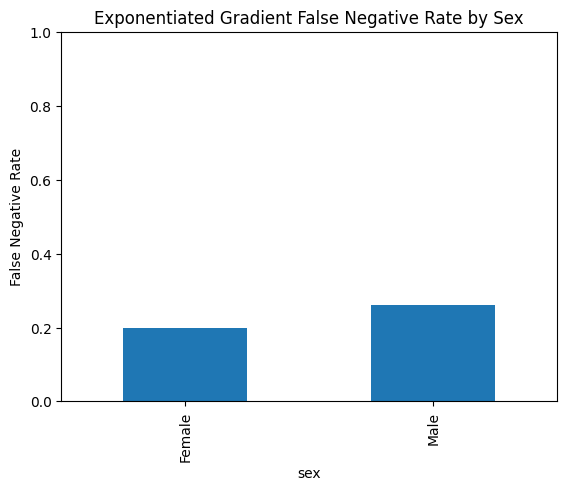

In [20]:
mf_exg = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test_debiased, y_pred=y_pred_exg,
    sensitive_features=g_test_debiased.replace({0: 'Female', 1: 'Male'})
)
print("Exponentiated Gradient False Negative Rate by sex:")
display(mf_exg.by_group)

mf_exg.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Exponentiated Gradient False Negative Rate by Sex'); plt.ylim(0, 1); plt.show()

## Threshold Optimizer Model

Another technique for addressing fairness disparities is threshold optimization, which adjusts the decision thresholds of a previously biased model to satisfy a fairness constraint. In this case, the initial baseline model is further refined using the `ThresholdOptimizer` with a false negative rate parity constraint. This approach modifies the decision thresholds for different sensitive groups, ensuring that false negative rates are more evenly distributed across groups (in this case, sex), while still maintaining overall predictive performance.

In [21]:
thresh_estimator = LogisticRegression(max_iter=1000, random_state=42)
thresh = ThresholdOptimizer(
    estimator=thresh_estimator,
    constraints="false_negative_rate_parity",
    prefit=False,
    predict_method='predict_proba'
)
thresh.fit(X_train.drop(columns=[sensitive_col], axis=1), y_train, sensitive_features=g_train)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   predict_method='predict_proba')

### Threshold Optimizer Model Accuracy Evaluation

Threshold optimization is used on the baseline model and evaluated for performance. These results show a decrease in performance (80.3% accuracy, 0.808 ROC AUC) compared to the baseline model, indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [22]:
y_pred_thr = thresh.predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test, random_state=42)
y_prob_thr = thresh._pmf_predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test) @ np.array([0,1])

acc_thr = accuracy_score(y_test, y_pred_thr)
auc_thr = roc_auc_score(y_test, y_prob_thr)

print("=== Threshold Optimizer Model ===")
print(f"Accuracy: {acc_thr:.3f}")
print(f"ROC AUC: {auc_thr:.3f}")

=== Threshold Optimizer Model ===
Accuracy: 0.803
ROC AUC: 0.808


### Threshold Optimizer Model Fairness Evaluation

After training the new model, fairness is accessed by measuring the false negative rate across sex groups. In this case, false negative rate is the proportion of individuals who actually have heart disease but were incorrectly classified as not having heart disease.

Compared to the baseline, threshold optimizing significantly reduces FNR for females, while only slightly increasing rates for males. This demonstrates that the post-processing adjustment succeeds in narrowing gaps between sex groups, even though it comes at the cost of reduced ROC AUC. These results show how powerful threshold optimization can be when limited to a pretrained biased model.

Threshold Optimizer False Negative Rate by sex:


,False Negative Rate
sex,
Female,0.20000
Male,0.26087


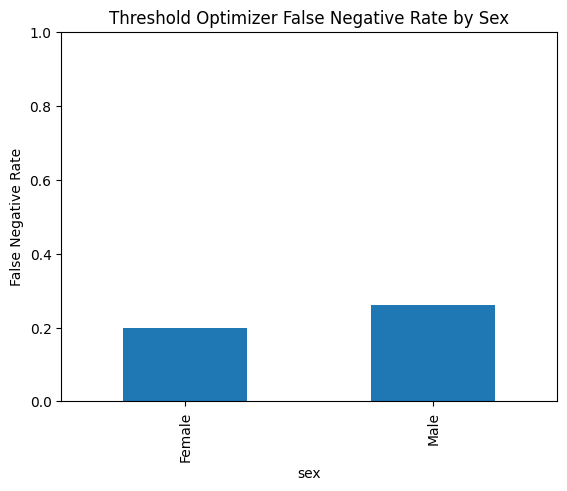

In [23]:
mf_thr = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test, y_pred=y_pred_thr,
    sensitive_features=g_test.replace({0: 'Female', 1: 'Male'})
)
print("Threshold Optimizer False Negative Rate by sex:")
display(mf_thr.by_group)

mf_thr.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Threshold Optimizer False Negative Rate by Sex'); plt.ylim(0, 1); plt.show()

## Model Evaluation

To evaluate the overall impact of fairness interventions, models are compared on three key dimensions: accuracy, ROC AUC, and false negative rate by sex. From the histogram plots, the relative differences across approaches are exposed.

Taken together, these comparisons highlight a trade-off: preprocessing and in-processing approaches deliver both improved accuracy and reduced disparities, while post-processing narrows group gaps but with a steep decline in ROC AUC. The choice of method therefore depends on whether predictive power or fairness improvements are prioritized in the deployment setting.

### Accuracy Rate Plots

The baseline logistic regression achieves an accuracy of 82.0%. Proxy debiasing lowers performance to 78.7% and exponentiated gradient improve performance substantially, reaching 82.0%, while threshold optimization lowers accuracy level to 80.3%. This suggests that preprocessing and in-processing methods not only reduce bias but can also enhance predictive accuracy.

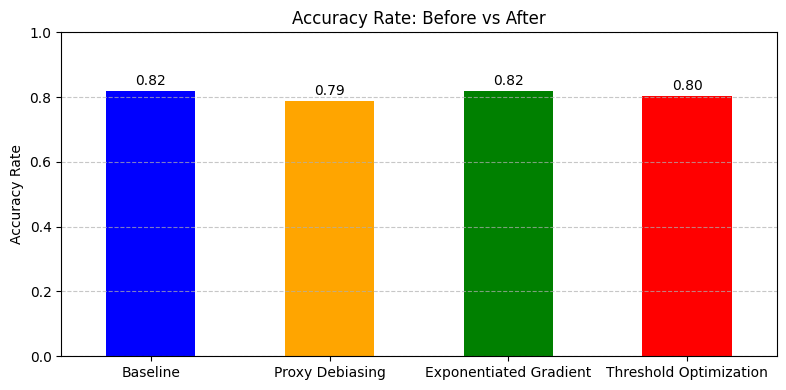

In [24]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_deb, acc_exg, acc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plots

The baseline model obtains a strong AUC of 0.878. Proxy debiasing diminishes discrimination to 0.856, whereas exponentiated gradient further decreases performance to 0.814. Threshold optimization shows the steepest decline, reducing AUC to 0.808, highlighting the cost of enforcing stricter fairness constraints at the decision threshold stage.

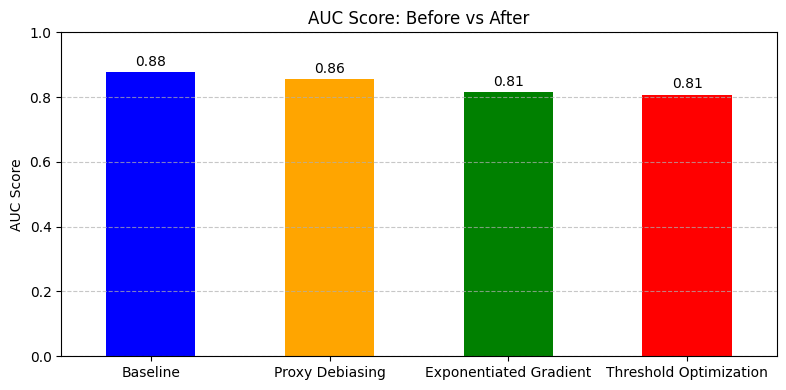

In [25]:
auc_comparison = pd.DataFrame({
    'AUC Rate': [auc, auc_deb, auc_exg, auc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
auc_series = auc_comparison['AUC Rate']

ax = auc_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('AUC Score'); plt.title('AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### False Negative Rate Plots

In the baseline model, false negatives are much higher for women (0.) compared to men (0.217), reflecting underdiagnosis in female patients. Proxy bebiasing narrows this disparity by lowering the rate for women to 0.400, though at the expense of increasing the rate for men to 0.261. Exponentiated gradient goes further, reducing the false negative rate for women to 0.200, while keeping the male rate similar to the previous (0.261). Threshold optimization improves fairness compared to baseline and proxy debiasing, yielding 0.20 for women and 0.261 for men.

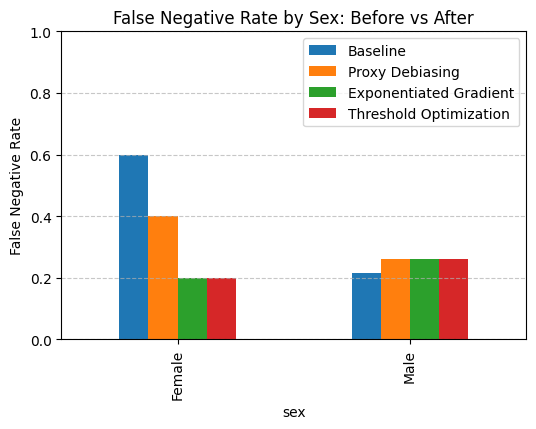

In [27]:
fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['False Negative Rate'],
    'Proxy Debiasing': mf_deb.by_group['False Negative Rate'],
    'Exponentiated Gradient': mf_exg.by_group['False Negative Rate'],
    'Threshold Optimization': mf_thr.by_group['False Negative Rate']
})
fairness_comparison.plot(kind='bar', figsize=(6,4))
plt.ylabel('False Negative Rate'); plt.title('False Negative Rate by Sex: Before vs After'); plt.ylim(0,1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

## Takeaways

This notebook demonstrated how fairness interventions can alter both the accuracy and equity of heart disease diagnosis models. By comparing proxy debiasing, exponentiated gradient, and threshold optimization, the pipeline showed how different fairness strategies affect predictive performance and group-level error rates. Proxy debiasing and exponentiated gradient both improved accuracy while reducing false negative rates for women, helping to mitigate sex-based underdiagnosis. Threshold optimization also narrowed disparities between male and female patients but introduced a notable decline in ROC AUC, limiting its clinical reliability.

Fairness does not come without trade-offs: stronger interventions can improve equity but at the expense of predictive power. In sensitive healthcare settings, these trade-offs must be considered carefully. A model that reduces disparities in false negative rates ensures that women are not systematically underdiagnosed with heart disease, even if some efficiency is lost. By situating fairness metrics alongside traditional performance measures, this workflow shows how practitioners can design diagnostic models that are not only accurate, but also equitable and clinically responsible.